In [260]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.stem import *
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime, timedelta, date
%matplotlib inline
plt.style.use('ggplot')

import nltk
import string

from nltk.corpus import stopwords
pstemmer = nltk.PorterStemmer()

In [261]:
y_col = 'variety_cleaned'

In [262]:
df = pd.read_csv('data/winemag-data-130k-v2.csv')

In [263]:
## Replace Commonly used diffirent names with the more common name
repl_dir = {'petite sirah': 'syrah', 
            'shiraz': 'syrah', 
            'champagne' :'sparkling',
           }

In [264]:
## Fill NA values to avoid Null errors
df_nona = df.fillna('NA')

In [265]:
### Remove all Blends and Wine Types made with more then one Grape
no_hyph = df_nona[df_nona['variety']\
                    .apply(lambda x: len(x.split('-')) < 2)]['variety'].str.lower()
no_hyph = no_hyph[no_hyph.apply(lambda x: x.split()[-1] != 'blend')].replace(repl_dir)

In [266]:
### Retain Only the Top 12 most common wine types
keep_vars = set(no_hyph.value_counts().head(12).index)

In [267]:
### Substitute out replaced names in main dataframe under new column name
### And reduce dataframe to only include top 12 most common grapes
df[y_col] = df['variety'].str.lower().replace(repl_dir)
df_noblends = df[df[y_col].replace(repl_dir).str.lower().isin(keep_vars)]

df_noblends[y_col].unique().size

12

In [268]:
### Generate Binary Classification Dataframe for Pinot Noir grapes to speed up 
### model performance evaluation
min_val = df_noblends[df_noblends[y_col] == 'pinot noir'].shape[0]
print(min_val)
is_pinot = df_noblends[df_noblends[y_col] == 'pinot noir'].sample(min_val)
not_pinot = df_noblends[df_noblends[y_col] != 'pinot noir'].sample(min_val)
ndf = pd.concat([is_pinot, not_pinot])

13272


In [269]:
ndf.shape

(26544, 15)

In [270]:
### Genrate mapping of numerical values to Grape names
classif_varieties = set(ndf[y_col].unique())
label_map = {val: idx for idx, val in enumerate(ndf[y_col].unique())}

In [271]:
label_map

{'cabernet sauvignon': 3,
 'chardonnay': 1,
 'malbec': 9,
 'merlot': 6,
 'nebbiolo': 4,
 'pinot noir': 0,
 'riesling': 5,
 'rosé': 2,
 'sangiovese': 10,
 'sauvignon blanc': 11,
 'syrah': 7,
 'zinfandel': 8}

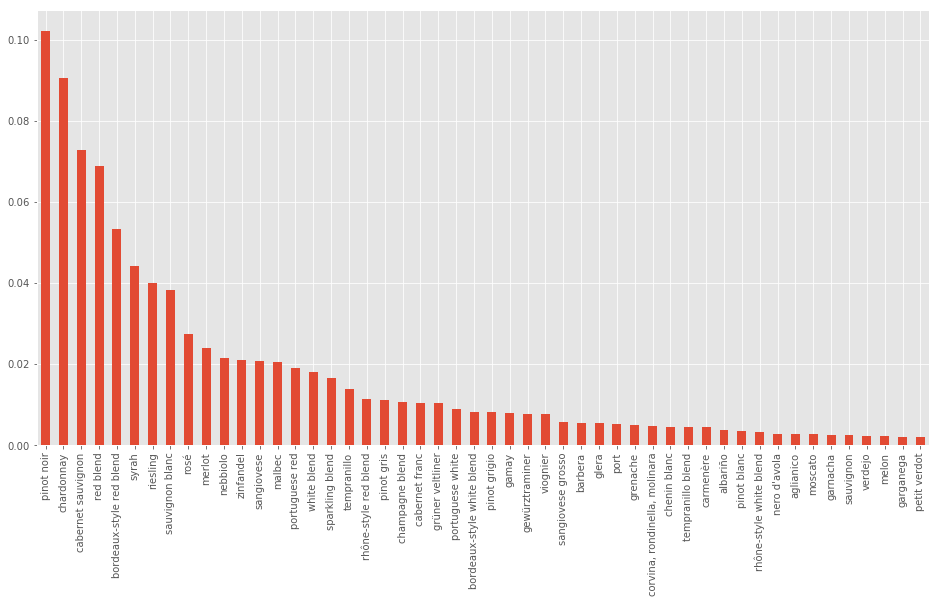

In [292]:
intr = df[y_col].value_counts(1).head(50)
plot = intr.plot(kind='bar', figsize=(16,8));
plot.set_xticklabels(intr.index, {'rotation' : 90});

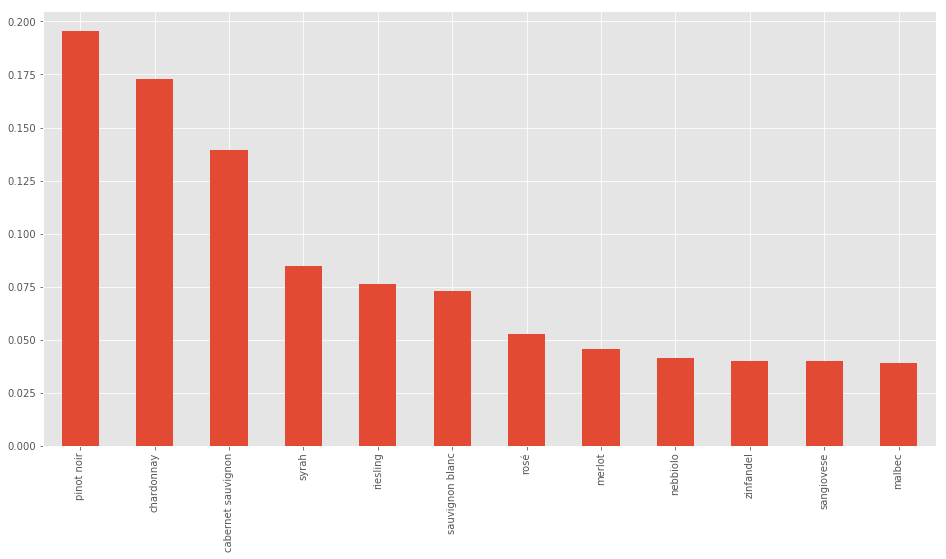

In [293]:
intr = df_noblends[y_col].value_counts(1)
plot = intr.plot(kind='bar', figsize=(16,8));
plot.set_xticklabels(intr.index, {'rotation' : 90});

In [272]:
y = ndf[y_col] == 'pinot noir'

In [273]:
### Remove stop words and use porterstemmer to generate word stems
reviews = ndf.description

swords = set(stopwords.words('english'))

ps = PorterStemmer()

word_vecs = reviews\
    .apply(lambda x: [re.sub("[\W]", '', i).lower().strip() for i in x.split()])\
    .apply(lambda x: [ps.stem(i) for i in x if i not in swords and len(i) > 3])

back2sent = word_vecs.apply(lambda x: ' '.join(x))

In [274]:
### Sample of clean descriptions
word_vecs.sample(10)

95021    [there, fullbodi, charact, wine, evidenc, siza...
93878    [offer, tuscan, coast, begin, floral, spice, f...
97623    [dark, juici, select, come, swing, bold, fruit...
15178    [open, cherri, liqueur, note, dark, concentr, ...
95576    [releas, less, year, wine, immatur, almost, ba...
92444    [almost, quit, undrink, veget, asparagusting, ...
87299    [archeri, summit, cuvé, young, brash, jangl, b...
93953    [style, pinot, almost, candi, flavor, cherri, ...
53492    [color, unusu, dark, pinot, noirto, deepli, fr...
25081    [dark, color, soft, nose, woodsi, cherri, scen...
Name: description, dtype: object

In [275]:
### Use Sklearn TfidfVectorizer to convert words into vectors
transform = TfidfVectorizer(lowercase=False, min_df=.01)
tf_idf_matrix = transform.fit_transform(back2sent.values)
tf_idf_matrix.shape

(26544, 406)

In [276]:
## build train_test_split
test_train = np.random.random(word_vecs.shape[0]) < .8
Xtr = tf_idf_matrix[test_train]
Xte = tf_idf_matrix[~test_train]
ytr = y[test_train]
yte = y[~test_train]

### Test Gaussian Naiive Bayes Model

In [277]:
from sklearn.naive_bayes import GaussianNB

In [278]:
start = datetime.now()
modelgb = GaussianNB()
modelgb.fit(Xtr.toarray(), ytr)
print(modelgb.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.826890439374
0


### Test Support Vector Machine Model

In [279]:
from sklearn.svm import SVC

In [280]:
start = datetime.now()
model_svm = SVC(C=1.0, kernel='rbf', degree=3, gamma=.05)
model_svm.fit(Xtr.toarray(), ytr)
print( model_svm.score(Xte.toarray(), yte))
print((datetime.now()-start).seconds)

0.870639260796
193


### Test Random Forest Model

In [281]:
from sklearn.ensemble import RandomForestClassifier

In [282]:
## 50 Tree model
start = datetime.now()
modelrf100 = RandomForestClassifier(n_estimators=50, n_jobs=-1).fit(Xtr.toarray(), ytr)
print(RandomForestClassifier(n_estimators=50, n_jobs=-1).fit(Xtr.toarray(), ytr)\
    .score(Xte.toarray(), yte))
# modelrf100.fit(Xtr.toarray(), ytr)
# print(modelrf100.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.887422213841
5


In [283]:
### 250 Tree model
start = datetime.now()
modelrf250 = RandomForestClassifier(n_estimators=250, n_jobs=-1)
modelrf250.fit(Xtr.toarray(), ytr)
print(modelrf250.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.890062228927
11


In [284]:
### 1000 Tree Model
start = datetime.now()
modelrf1k = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
modelrf1k.fit(Xtr.toarray(), ytr)
print(modelrf1k.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.887045068829
43


### Test XGboost Model

In [285]:
import xgboost as xgb

In [286]:
### Test with max_depth of 3
start = datetime.now()
modelxg3 = xgb.XGBClassifier(max_depth=3, learning_rate=.05, n_estimators=250, n_jobs=-1)
modelxg3.fit(Xtr.toarray(), ytr)
print(modelxg3.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.85630775033
14


In [287]:
### Test with max_depth of 5
start = datetime.now()
modelxg5 = xgb.XGBClassifier(max_depth=10, learning_rate=.05, n_estimators=250, n_jobs=-1)
modelxg5.fit(Xtr.toarray(), ytr)
print(modelxg5.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.885347916274
42


In [288]:
### Test with max_depth of 15 and learning rate of .1
start = datetime.now()
modelxg_lr1 = xgb.XGBClassifier(max_depth=15, learning_rate=.1, n_estimators=250, n_jobs=-1)
modelxg_lr1.fit(Xtr.toarray(), ytr)
print(modelxg_lr1.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.891947953988
67


In [289]:
### Test with max_depth of 50 learning rate of .1 and 1000 Trees
start = datetime.now()
modelxg_t1000 = xgb.XGBClassifier(max_depth=50, learning_rate=.1, n_estimators=1000, n_jobs=-1)
modelxg_t1000.fit(Xtr.toarray(), ytr)
print(modelxg_t1000.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.892513671507
833


### Test GradientBoosted Decision Trees Model

In [290]:
from sklearn.ensemble import GradientBoostingClassifier

In [291]:
start = datetime.now()
modelgbf_t250 = GradientBoostingClassifier(max_depth=5,
                                           learning_rate=.1, 
                                           n_estimators=250)
modelgbf_t250.fit(Xtr.toarray(), ytr)
print(modelgbf_t250.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.880445031114
220


### Optimizing Document Frequency

In [116]:
reviews = ndf.description
y = ndf[y_col] == 'pinot noir'

swords = set(stopwords.words('english'))

ps = PorterStemmer()

word_vecs = reviews\
    .apply(lambda x: [re.sub("[\W]", '', i).lower().strip() for i in x.split()])\
    .apply(lambda x: [ps.stem(i) for i in x if i not in swords and len(i) > 3])

back2sent = word_vecs.apply(lambda x: ' '.join(x))

test_train = np.random.random(ndf.shape[0]) < .8
ytr = y[test_train]
yte = y[~test_train]

In [137]:
scores = {}

mod_params = {'max_depth':10, 'learning_rate':.1, 'n_estimators' :50, 'n_jobs': -1}

for i in np.linspace(.0005, .005, 20):
    for n in range(1,4):
        start = datetime.now()
        tfidf = TfidfVectorizer(lowercase=False, min_df=i, ngram_range=(1,n))\
                .fit_transform(back2sent.values)
        Xtr = tfidf[test_train]
        Xte = tfidf[~test_train]
        try: 
            scores[n].append((i, (datetime.now() - start).total_seconds(), Xtr.shape[1],
                             xgb.XGBClassifier(**mod_params)\
                                .fit(Xtr.toarray(), ytr).score(Xte.toarray(), yte)))
        except KeyError:
            scores[n] = [(i, (datetime.now() - start).total_seconds(), 
                          xgb.XGBClassifier(**mod_params)\
                            .fit(Xtr.toarray(), ytr).score(Xte.toarray(), yte))]

In [148]:
scoresdf = {}
for key in scores.keys():
    scoresdf[key] = pd.DataFrame(scores[key])
    scoresdf[key].columns = ['min_df', 'time_taken', 'score']

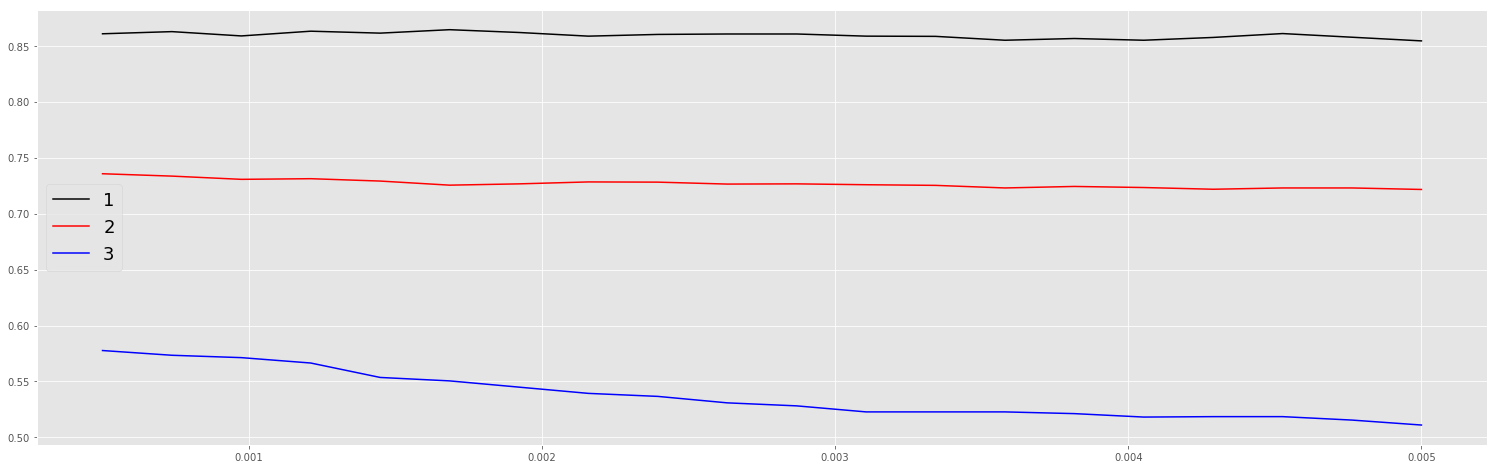

In [152]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
colors =[None, 'black', 'red', 'blue']
for key, vals in scoresdf.items():
    plt.plot(vals['min_df'], vals['score'], color=colors[key], label=key)
plt.legend(fontsize=18)

In [154]:
scores = {}

mod_params = {'max_depth':10, 'learning_rate':.1, 'n_estimators' :50, 'n_jobs': -1}

for i in np.linspace(.003, .011, 8):
    for n in range(1,4):
        start = datetime.now()
        tfidf = TfidfVectorizer(lowercase=False, min_df=i, ngram_range=(1,n))\
                .fit_transform(back2sent.values)
        Xtr = tfidf[test_train]
        Xte = tfidf[~test_train]
        try: 
            scores[n].append((i, (datetime.now() - start).total_seconds(), Xtr.shape[1],
                             xgb.XGBClassifier(**mod_params)\
                                .fit(Xtr.toarray(), ytr).score(Xte.toarray(), yte)))
        except KeyError:
            scores[n] = [(i, (datetime.now() - start).total_seconds(), 
                          xgb.XGBClassifier(**mod_params)\
                            .fit(Xtr.toarray(), ytr).score(Xte.toarray(), yte))]

In [164]:
scoresdf = {}
for key in scores.keys():
    scoresdf[key] = pd.DataFrame(scores[key])
    scoresdf[key].columns = ['min_df', 'time_taken', 'num_cols', 'score']

In [169]:
scoresdf[1].head(20)

,min_df,time_taken,num_cols,score
0,0.003000,0.624589,0.857418,NaN
1,0.004143,0.684931,838.000000,0.856648
2,0.005286,0.685596,688.000000,0.856071
3,0.006429,0.664706,593.000000,0.854724
4,0.007571,0.697727,527.000000,0.853377
5,0.008714,0.684950,456.000000,0.849721
6,0.009857,0.693704,408.000000,0.853569
7,0.011000,0.672942,381.000000,0.847604


#### Plot of Minimum Document Frequency vs Model Accuracy
* Colors represent n-gram size

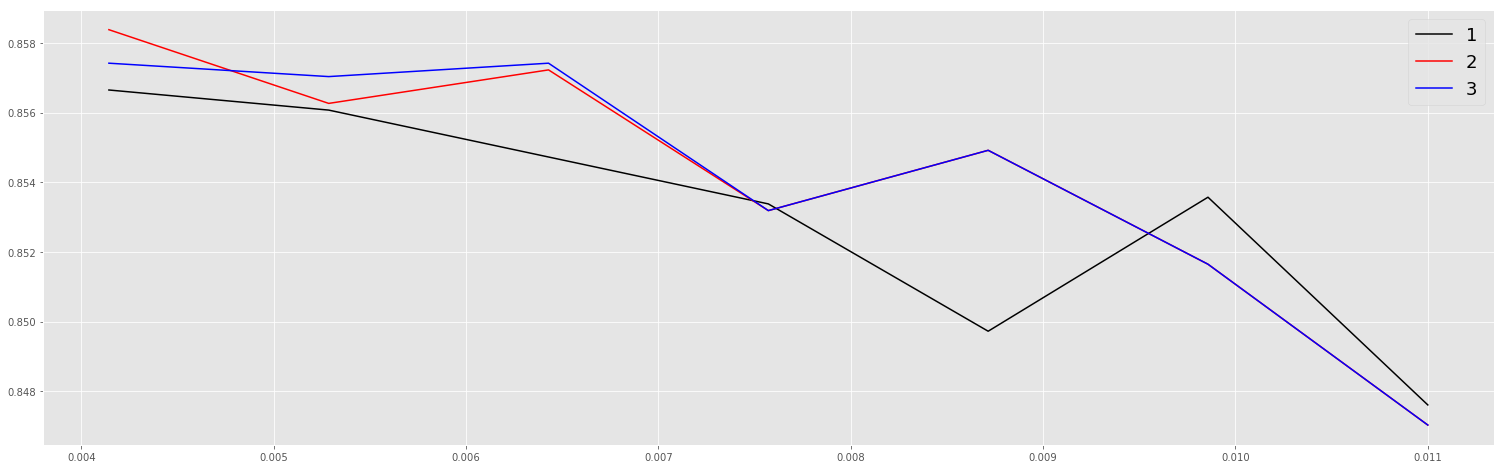

In [168]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
colors =[None, 'black', 'red', 'blue']
for key, vals in scoresdf.items():
    plt.plot(vals['min_df'], vals['score'], color=colors[key], label=key)
plt.legend(fontsize=18)

### Number of Features

In [207]:
feat_scores = {}

mod_params = {'max_depth':10, 'learning_rate':.1, 'n_estimators' :50, 'n_jobs': -1}

for i in np.logspace(4, 12, 32, base=2):
    for n in range(1,4):
        start = datetime.now()
        tfidf = TfidfVectorizer(lowercase=False, max_df=.1, max_features=int(i), ngram_range=(1,n))\
                .fit_transform(back2sent.values)
        Xtr = tfidf[test_train]
        Xte = tfidf[~test_train]
        try: 
            feat_scores[n].append((i, (datetime.now() - start).total_seconds(), Xtr.shape[1],
                             xgb.XGBClassifier(**mod_params)\
                                .fit(Xtr.toarray(), ytr).score(Xte.toarray(), yte)))
        except KeyError:
            feat_scores[n] = [(i, (datetime.now() - start).total_seconds(), 
                          xgb.XGBClassifier(**mod_params)\
                            .fit(Xtr.toarray(), ytr).score(Xte.toarray(), yte))]

#### Plot of number of total features vs Model accuracy
* Colors represent max number of n-grams allowed

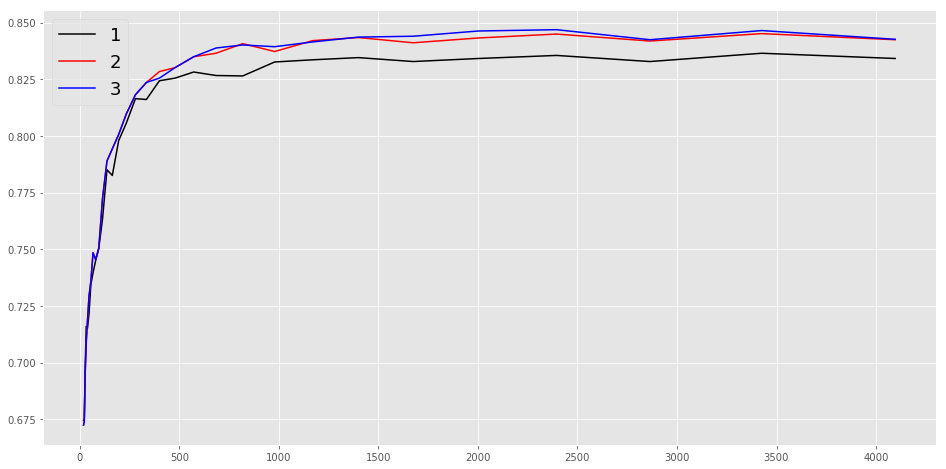

In [208]:
scoresdf_nfeats = {}
for key in feat_scores.keys():
    scoresdf_nfeats[key] = pd.DataFrame(feat_scores[key])
    scoresdf_nfeats[key].columns = ['max_features', 'time_taken', 'num_cols', 'score']
    
fig, ax = plt.subplots(1,1, figsize=(16,8))
colors =[None, 'black', 'red', 'blue']
for key, vals in scoresdf_nfeats.items():
    plt.plot(vals['max_features'], vals['score'], color=colors[key], label=key)
plt.legend(fontsize=18)

In [294]:
print(scoresdf_nfeats[1]['time_taken']
      + scoresdf_nfeats[2]['time_taken']
      + scoresdf_nfeats[3]['time_taken'])

0     8.953062
1     8.574032
2     8.922835
3     8.361901
4     8.373501
5     9.126847
6     9.205494
7     8.473781
8     9.229250
9     9.067835
10    9.027249
11    9.121979
12    8.806158
13    8.270761
14    7.987192
15    8.809887
16    8.696499
17    9.144378
18    8.783129
19    8.923737
20    8.666150
21    8.650914
22    8.553759
23    8.618298
24    8.716536
25    8.647685
26    8.872359
27    8.484221
28    8.476637
29    8.485876
30    8.416390
31    8.823613
Name: time_taken, dtype: float64


### Number of Trees

In [184]:
tree_scores = []


tfidf = TfidfVectorizer(lowercase=False, min_df=.0098, ngram_range=(1,2))\
            .fit_transform(back2sent.values)
Xtr = tfidf[test_train]
Xte = tfidf[~test_train]

mod_params = {'max_depth':10, 'learning_rate':.1, 'n_jobs': -1}

for i in np.logspace(5, 12, 21, base=2):
    mod_params['n_estimators'] = int(i)
    start = datetime.now()
    tree_scores.append((i, (datetime.now() - start).total_seconds(), Xtr.shape[1],
                         xgb.XGBClassifier(**mod_params)\
                            .fit(Xtr.toarray(), ytr).score(Xte.toarray(), yte)))

In [204]:
scoresdf = pd.DataFrame(tree_scores)
scoresdf.columns = ['n_estimators', 'time_taken', 'num_cols', 'score']

#### Plot of number of trees vs Model Accuracy

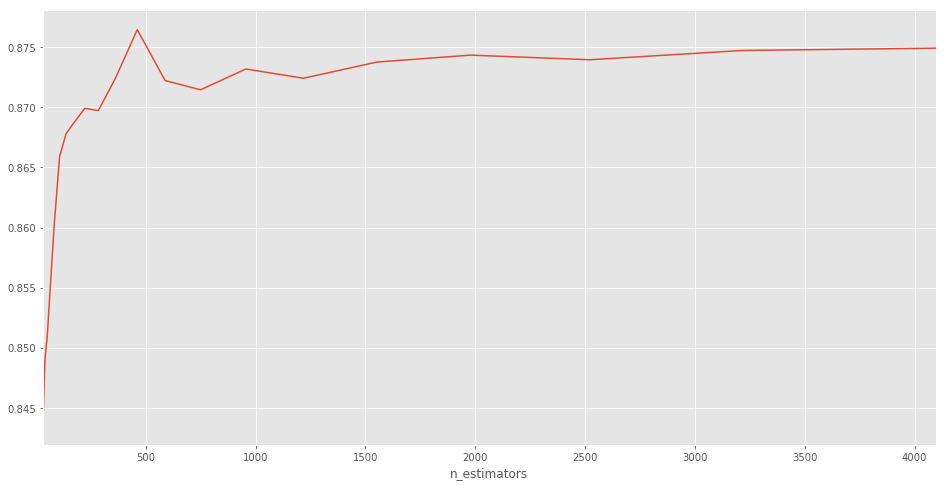

In [205]:
scoresdf.set_index('n_estimators')['score'].plot(figsize=(16,8))

In [187]:
print(scoresdf['time_taken'].sum())

0.00017200000000000003


### Max Tree Depth

In [188]:
depth_scores = []


tfidf = TfidfVectorizer(lowercase=False, min_df=.0098, ngram_range=(1,2))\
            .fit_transform(back2sent.values)
Xtr = tfidf[test_train]
Xte = tfidf[~test_train]

mod_params = {'max_depth':10, 'learning_rate':.1, 'n_estimators' :50, 'n_jobs': -1}

for i in np.arange(1, 20):
    mod_params['max_depth'] = int(i)
    start = datetime.now()
    depth_scores.append((i, (datetime.now() - start).total_seconds(), Xtr.shape[1],
                         xgb.XGBClassifier(**mod_params)\
                            .fit(Xtr.toarray(), ytr).score(Xte.toarray(), yte)))

In [190]:
depthdf = pd.DataFrame(depth_scores)
depthdf.columns = ['max_depth', 'time_taken', 'num_cols', 'score']

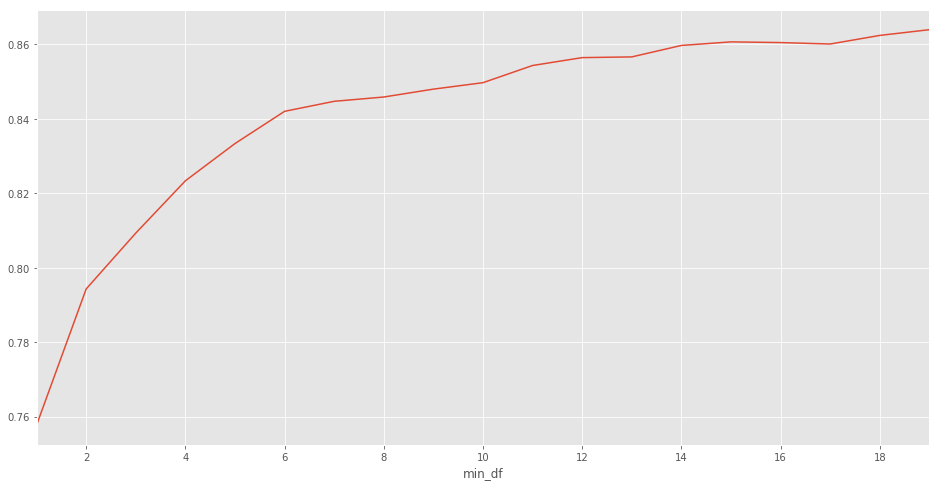

In [191]:
depthdf.set_index('max_depth')['score'].plot(figsize=(16,8))

In [192]:
print(depthdf['time_taken'].sum())

0.00015900000000000004


In [193]:
# dense_matrix = pd.DataFrame(tf_idf_matrix.todense())

# ## these may be in order of count, not the orde of the columns so this is were i messed up
# dense_matrix.columns = [v for v in transform.vocabulary_.keys()]

# dense_matrix.columns

# dense_matrix.sample(10)

# country_dm = dense_matrix.copy()

# country_dm['y'] = df['country']

In [194]:
start = datetime.now()
#process things
print((datetime.now() - start).seconds)

0


### Learning Rate

In [200]:
lr_scores = []

tfidf = TfidfVectorizer(lowercase=False, min_df=.0098, ngram_range=(1,2))\
            .fit_transform(back2sent.values)
Xtr = tfidf[test_train]
Xte = tfidf[~test_train]

mod_params = {'max_depth':10, 'learning_rate':.1, 'n_estimators' :100, 'n_jobs': -1}

for i in np.linspace(.01, .11, 10):
    mod_params['learning_rate'] = i
    start = datetime.now()
    lr_scores.append((i, (datetime.now() - start).total_seconds(), Xtr.shape[1],
                         xgb.XGBClassifier(**mod_params)\
                            .fit(Xtr.toarray(), ytr).score(Xte.toarray(), yte)))

In [201]:
lr_scores_df = pd.DataFrame(lr_scores)
lr_scores_df.columns = ['learn_rate', 'time_taken', 'num_cols', 'score']

### Plot of Learning Rate vs model Accuracy with 100 trees max depth of 10

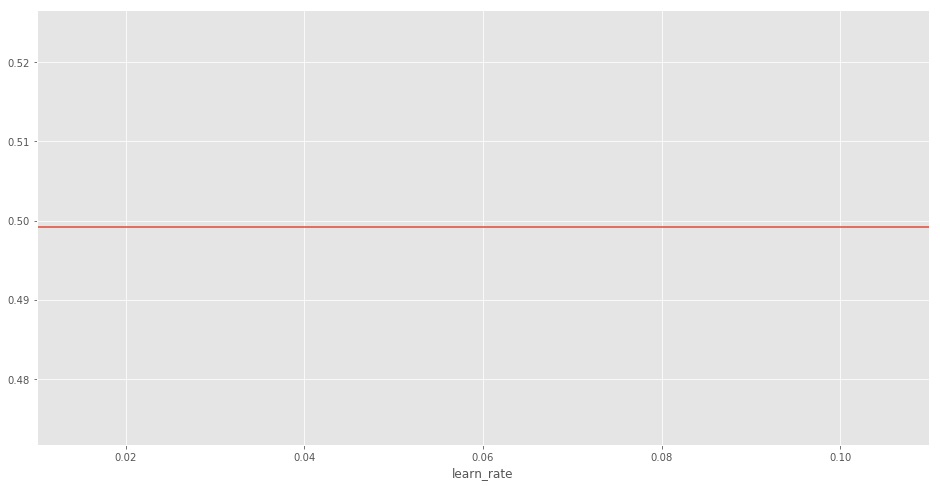

In [202]:
lr_scores_df.set_index('learn_rate')['score'].plot(figsize=(16,8))

In [203]:
print(lr_scores_df['time_taken'].sum())

8.5e-05


### Optimal model

In [229]:
label_map = {val: idx for idx, val in enumerate(ndf[y_col].unique())}
y = df_noblends[y_col].replace(label_map).values

In [213]:
min_val = df_noblends['variety'].value_counts().tail(1).values[0]

print(min_val)
list_of_dfs = []
for x in df_noblends[y_col].unique():
    list_of_dfs.append(df_noblends[df_noblends[y_col] == x].sample(min_val))
ndf_all = pd.concat(list_of_dfs)

770


In [ ]:
ndf_all.shape

In [226]:
reviews = ndf.description
swords = set(stopwords.words('english'))
ps = PorterStemmer()

word_vecs = reviews\
    .apply(lambda x: [re.sub("[\W]", '', i).lower().strip() for i in x.split()])\
    .apply(lambda x: [ps.stem(i) for i in x if i not in swords and len(i) > 3])

In [246]:
## Ideal max_features was found to be 2,000, but this took too long to run
back2sent = word_vecs.apply(lambda x: ' '.join(x))
transform = TfidfVectorizer(lowercase=False, max_df=.1, max_features=2000, ngram_range=(1,3))
tf_idf_matrix = transform.fit_transform(back2sent.values)

In [248]:
## Generate Cross validation set
rand_vals = np.random.random(word_vecs.shape[0])

cv_set = []
k= 5

for val in np.linspace(0,1-1/k,k):
    test_train = ((rand_vals <= val) | (rand_vals > val + 1.0/k))
    cv_set.append({'Xtr': tf_idf_matrix[test_train],
                    'Xte': tf_idf_matrix[~test_train],
                    'ytr': y[test_train],
                    'yte': y[~test_train]
                  })

/Users/travis/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 67944 but corresponding boolean dimension is 26544
  # This is added back by InteractiveShellApp.init_path()
/Users/travis/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 67944 but corresponding boolean dimension is 26544
  if sys.path[0] == '':


In [239]:
## This would have been the optimial system, but we don't have time to run it (26 hours)
## Check Identified Optimal model parameters on Cross-validated set (k= 5)
mod_params = {'max_depth':25, 'learning_rate':.1, 'n_estimators' :3000, 'n_jobs': -1}
cv_scores = []

for tt_set in cv_set:
    cv_scores.append(xgb.XGBClassifier(**mod_params)\
                        .fit(tt_set['Xtr'].toarray(), tt_set['ytr'])\
                        .score(tt_set['Xte'].toarray(), tt_set['yte']))

In [249]:
### So we had to do this one to get a model running in time
mod_params = {'max_depth':15, 'learning_rate':.1, 'n_estimators': 100, 'n_jobs': -1}
cv_scores = []

for tt_set in cv_set:
    cv_scores.append(xgb.XGBClassifier(**mod_params)\
                        .fit(tt_set['Xtr'].toarray(), tt_set['ytr'])\
                        .score(tt_set['Xte'].toarray(), tt_set['yte']))
    print(datetime.now())

2018-07-08 22:34:35.495523
2018-07-08 22:42:26.826335
2018-07-08 22:50:35.882497
2018-07-08 22:59:13.104634
2018-07-08 23:07:56.648515


In [251]:
cv_scores

[0.16660327120578167,
 0.18097227497151538,
 0.17336309523809523,
 0.16672996581845803,
 0.16957976943101524]

In [250]:
print(np.array(cv_scores).mean())

0.171449675333
